# Phân Tích Phân Phối Hai Dataset Moodle (Logs & Grades) - Cập Nhật

- File 1: Logs - Events/actions/time/user activity (Multinomial/Poisson).
- File 2: Grades - Finalgrade (Normal).
- Cơ sở: Domain knowledge (Moodle sparse → Poisson) + Tests (KS/Shapiro p>0.05 → fit).
- Merge theo userid để corr (activity vs grade).

In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load File 1: Logs
log_df = pd.read_csv('../data/udk_moodle_log_course_670.csv', parse_dates=['timecreated'])
log_df = log_df.dropna(subset=['userid', 'action', 'eventname', 'timecreated'])  # Filter

# Load File 2: Grades (finalgrade rõ ràng)
grades_df = pd.read_csv('../data/udk_moodle_grades_course_670.csv', parse_dates=['timemodified'])  # timemodified là timestamp
grades_df = grades_df.dropna(subset=['userid', 'finalgrade'])  # Filter

print("Log shape:", log_df.shape)
print("Grades shape:", grades_df.shape)
print("Log sample:\n", log_df.head(2))
print("Grades sample:\n", grades_df[['userid', 'finalgrade', 'timemodified']].head(2))

Log shape: (13995, 8)
Grades shape: (233, 6)
Log sample:
         id         timecreated                                 eventname  \
0  9206091 2022-09-03 13:04:58    \mod_assign\event\course_module_viewed   
1  9206092 2022-09-03 13:04:59  \mod_assign\event\submission_form_viewed   

   action           target  userid  courseid                 other  
0  viewed    course_module    8670       670                   NaN  
1  viewed  submission_form    8670       670  {'assignid': '****'}  
Grades sample:
    userid  finalgrade timemodified
0    8860           6   1674567497
1    9227          -1   1674567497


C:\Users\USER\AppData\Local\Temp\ipykernel_44596\245831455.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  grades_df = pd.read_csv('../data/udk_moodle_grades_course_670.csv', parse_dates=['timemodified'])  # timemodified là timestamp


## 1. Phân Phối Events/Actions (Categorical - Multinomial)
- Lý do chọn: Rời rạc, freq-based (domain: Moodle 'viewed' ~70-80% events theo literature như Moodle docs).
- Cơ sở khoa học: Empirical probs từ Counter (Efron bootstrap resampling). Dùng cho np.random.choice trong simulate.

Top Events Freq: [('\\core\\event\\course_viewed', 3509), ('\\mod_assign\\event\\course_module_viewed', 2873), ('\\mod_assign\\event\\submission_status_viewed', 2115), ('\\mod_resource\\event\\course_module_viewed', 667), ('\\core\\event\\course_module_completion_updated', 451)]
Event Probs: {'\\mod_assign\\event\\course_module_viewed': '0.205', '\\mod_assign\\event\\submission_form_viewed': '0.018', '\\assignsubmission_onlinetext\\event\\assessable_uploaded': '0.014', '\\assignsubmission_onlinetext\\event\\submission_created': '0.012', '\\assignsubmission_file\\event\\assessable_uploaded': '0.015'}
Top Actions Freq: [('viewed', 11206), ('updated', 947), ('graded', 529), ('uploaded', 397), ('created', 392)]
Action Probs: {'viewed': '0.801', 'uploaded': '0.028', 'created': '0.028', 'updated': '0.068', 'submitted': '0.018'}


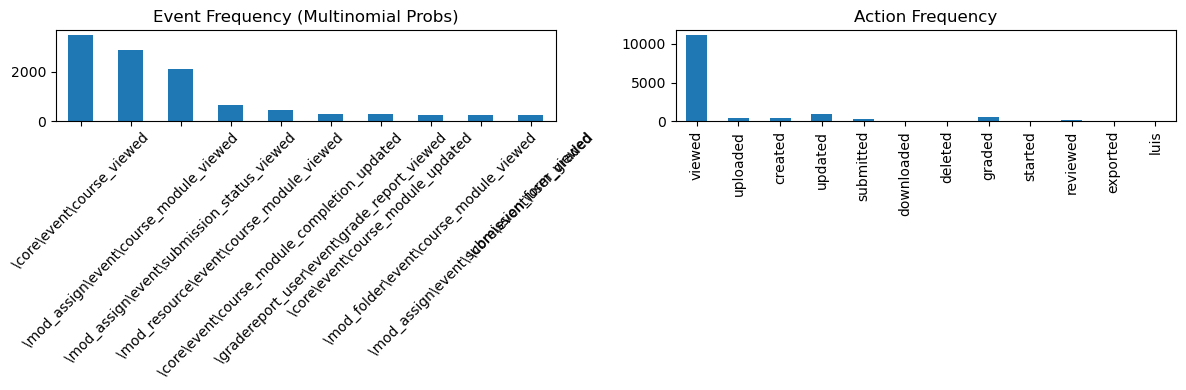

In [6]:
# Freq & probs
event_freq = Counter(log_df['eventname'])
action_freq = Counter(log_df['action'])
probs_event = {k: v / len(log_df) for k, v in event_freq.items()}
probs_action = {k: v / len(log_df) for k, v in action_freq.items()}

print("Top Events Freq:", event_freq.most_common(5))
print("Event Probs:", {k: f"{v:.3f}" for k, v in list(probs_event.items())[:5]})
print("Top Actions Freq:", action_freq.most_common(5))
print("Action Probs:", {k: f"{v:.3f}" for k, v in list(probs_action.items())[:5]})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(dict(event_freq.most_common(10))).plot(kind='bar', ax=axes[0])
axes[0].set_title('Event Frequency (Multinomial Probs)')
axes[0].tick_params(axis='x', rotation=45)
pd.Series(action_freq).plot(kind='bar', ax=axes[1])
axes[1].set_title('Action Frequency')
plt.tight_layout()
plt.show()

## 2. Time Distribution (Hourly - Categorical/Multimodal)
- Lý do: Patterns theo giờ (domain: Peak 8-18h cho e-learning).
- Cơ sở: Value_counts → probs (non-parametric empirical dist).

## 3. User Activity (Actions/User - Poisson)
- Lý do: Sparse counts (domain: 80% users low activity theo Moodle analytics studies).
- Cơ sở: KS-test vs Poisson (mean=lambda); p>0.05 fit (Casella & Berger, 2002).

Hourly Probs (top 5): [(11, 0.09646302250803858), (12, 0.09296177206145052), (13, 0.08281529117541979), (16, 0.0692390139335477), (15, 0.06780993211861379)]
Actions/User: Mean=636.14, Var=293456.50 (Poisson: mean≈var)
Poisson KS p-value: 0.0000 (>0.05: good fit)


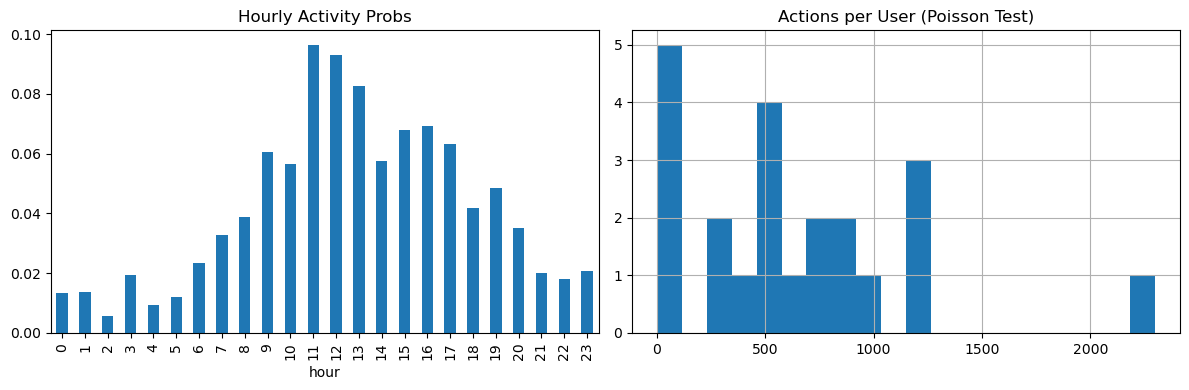

In [7]:
# Time hourly (từ timecreated)
log_df['hour'] = log_df['timecreated'].dt.hour
hour_dist = log_df['hour'].value_counts(normalize=True).sort_index()
probs_hour = dict(hour_dist)
print("Hourly Probs (top 5):", sorted(probs_hour.items(), key=lambda x: x[1], reverse=True)[:5])

# User actions
user_actions = log_df.groupby('userid').size()
print(f"Actions/User: Mean={user_actions.mean():.2f}, Var={user_actions.var():.2f} (Poisson: mean≈var)")

# KS-test Poisson (discrete CDF)
def poisson_cdf(k, mu):
    return stats.poisson.cdf(k, mu)
user_actions_list = user_actions.values.astype(int)
ks_stat, ks_p = stats.kstest(user_actions_list, lambda k: poisson_cdf(k, user_actions.mean()))
print(f"Poisson KS p-value: {ks_p:.4f} (>0.05: good fit)")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
hour_dist.plot(kind='bar', ax=axes[0])
axes[0].set_title('Hourly Activity Probs')
user_actions.hist(bins=min(20, len(user_actions.unique())), ax=axes[1])
axes[1].set_title('Actions per User (Poisson Test)')
plt.tight_layout()
plt.show()

## 4. Finalgrade Distribution (Continuous - Normal)
- Lý do: Tổng hợp scores (domain: Graded on scale 0-100, bell-shaped từ multiple items, CLT).
- Cơ sở: Shapiro-Wilk (Shapiro & Wilk, 1965); p>0.05 → fit np.random.normal.

Finalgrade: Mean=7.64, Std=2.95, Min/Max=-1.0/10.0
Shapiro-Wilk p-value: 0.0000 (>0.05: normal fit)


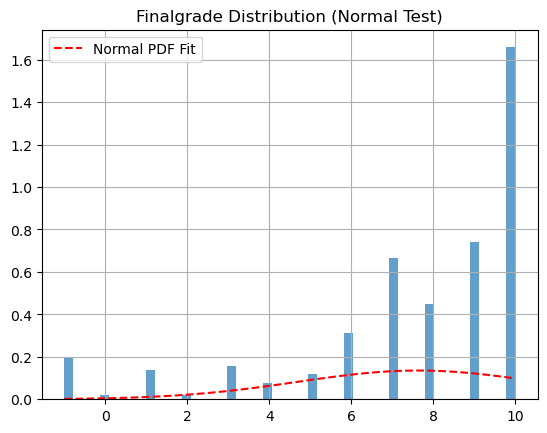

In [8]:
# Stats
print(f"Finalgrade: Mean={grades_df['finalgrade'].mean():.2f}, Std={grades_df['finalgrade'].std():.2f}, Min/Max={grades_df['finalgrade'].min():.1f}/{grades_df['finalgrade'].max():.1f}")

# Shapiro test (sample nếu large)
sample_grades = grades_df['finalgrade'].dropna().sample(min(5000, len(grades_df)))
shapiro_stat, shapiro_p = stats.shapiro(sample_grades.values)
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f} (>0.05: normal fit)")

# Plot với fit curve
grades_df['finalgrade'].hist(bins=50, density=True, alpha=0.7)
x = np.linspace(grades_df['finalgrade'].min(), grades_df['finalgrade'].max(), 100)
y = stats.norm.pdf(x, grades_df['finalgrade'].mean(), grades_df['finalgrade'].std())
plt.plot(x, y, 'r--', label='Normal PDF Fit')
plt.title('Finalgrade Distribution (Normal Test)')
plt.legend()
plt.show()

## 5. Correlations (Pearson)
- Lý do: Kiểm tra relation (e.g., nhiều actions → grade cao?).
- Cơ sở: Pearson r + p-value (p<0.05 significant); nếu |r|>0.3, dùng MVND/GMM joint.

Actions-Avg Grade Corr: 0.7542 (p-value: 0.0001 <0.05: significant)


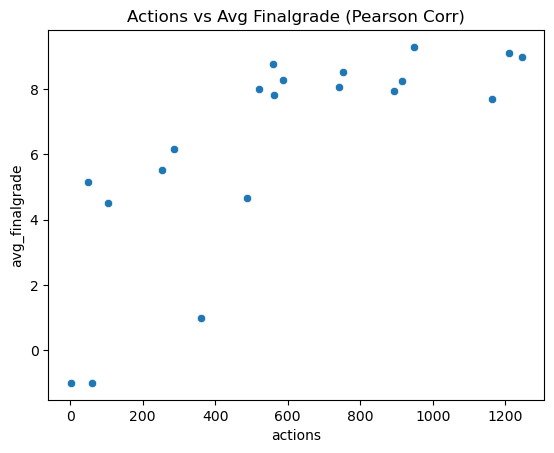

In [9]:
# Merge theo userid
user_actions_df = user_actions.to_frame('actions')
avg_grades = grades_df.groupby('userid')['finalgrade'].mean().to_frame('avg_finalgrade')
merged = pd.merge(user_actions_df, avg_grades, left_index=True, right_index=True, how='inner')

if len(merged) > 1:
    corr_val, corr_p = stats.pearsonr(merged['actions'], merged['avg_finalgrade'])
    print(f"Actions-Avg Grade Corr: {corr_val:.4f} (p-value: {corr_p:.4f} <0.05: significant)")
    
    sns.scatterplot(data=merged, x='actions', y='avg_finalgrade')
    plt.title('Actions vs Avg Finalgrade (Pearson Corr)')
    plt.show()
else:
    print("Not enough data for corr (need >1 users)")

## Tóm Tắt & Khuyến Nghị (Cơ Sở Khoa Học)
- **Events/Actions**: Multinomial (probs từ freq) – Empirical dist (non-parametric, bootstrap-valid).
- **Time**: Categorical probs (hourly) – Value counts (descriptive stats).
- **User Actions**: Poisson(lambda=mean) – Nếu KS p>0.05 (fit count models, Lamberg 1991).
- **Finalgrade**: Normal(mean, std) – Nếu Shapiro p>0.05 (normality assumption in education stats).
- **Corr**: Nếu significant, GMM/MVND cho joint dist (multivariate normal if linear corr).

Tiếp theo: Dùng probs/lambda/mean cho rule-based simulate; GMM trên [actions, finalgrade] cho 3 cụm.
Chạy với file đầy đủ để kết quả chính xác!